In [135]:
from __future__ import division
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.linalg as sl
import os
import time
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import libstempo as T
from enterprise.signals.selections import Selection
import sys 
import scipy.linalg as sl, scipy.stats, scipy.special

In [18]:
bparfile = 'B1855+09_NANOGrav_12yv3.gls.par'
btimfile = 'B1855+09_NANOGrav_12yv3.tim'

In [20]:
jparfile = 'J0023+0923_NANOGrav_12yv3.gls.par'
jtimfile = 'J0023+0923_NANOGrav_12yv3.tim'

In [19]:
psrb = Pulsar(bparfile,btimfile)

In [21]:
psrj = Pulsar(jparfile,jtimfile)

In [23]:
class Gibbs(object):
    def __init__(self, pta, model = "mixture", tdf=4, m=0.01,
                 vary_df=True, theta_prior='beta', vary_alpha= True,
                 alpha=1e10, pspin=None):

        self.pta = pta

        # a-prior outlier probability
        self.mp = m 
        self.theta_prior = theta_prior

        # spin period
        self.pspin = pspin

        # vary t-distribution d.o.f
        self.vary_df = vary_df

        # vary alpha
        self.vary_alpha = vary_alpha

        # For now assume one pulsar
        self._residuals = self.pta.get_residuals()[0]

        # which likelihood model
        self._lmodel = model

        # auxiliary variable 
        xs = [p.sample() for p in pta.params]
        self._b = np.zeros(self.pta.get_basis(xs)[0].shape[1])

        # for caching
        self.TNT = None
        self.d = None

        # outlier stuff
        self._pout = np.zeros_like(self._residuals)
        self._z = np.zeros_like(self._residuals)
        if not vary_alpha:
            self._alpha = np.ones_like(self._residuals) * alpha
        else:
            self._alpha = np.ones_like(self._residuals)
        self._theta = self.mp
        self.tdf = tdf
        if model in ['t', 'mixture', 'vvh17']:
            self._z = np.ones_like(self._residuals)

    @property
    def params(self):
        ret = []
        for param in self.pta.params:
            ret.append(param)
        return ret

    def map_params(self, xs):
        return {par.name: x for par, x in zip(self.params, xs)}


    def get_hyper_param_indices(self):
        ind = []
        for ct, par in enumerate(self.params):
            if 'ecorr' in par.name or 'log10_A' in par.name or 'gamma' in par.name:
                ind.append(ct)
        return np.array(ind)


    def get_white_noise_indices(self):
        ind = []
        for ct, par in enumerate(self.params):
            if 'efac' in par.name or 'equad' in par.name:
                ind.append(ct)
        return np.array(ind)


    def update_hyper_params(self, xs):

        # get hyper parameter indices
        hind = self.get_hyper_param_indices()

        # get initial log-likelihood and log-prior
        lnlike0, lnprior0 = self.get_lnlikelihood(xs), self.get_lnprior(xs)
        xnew = xs.copy()
        for ii in range(10):

            # standard gaussian jump (this allows for different step sizes)
            q = xnew.copy()
            sigmas = 0.05 * len(hind)
            probs = [0.1, 0.15, 0.5, 0.15, 0.1]
            sizes = [0.1, 0.5, 1.0, 3.0, 10.0]
            scale = np.random.choice(sizes, p=probs)
            par = np.random.choice(hind, size=1)
            q[par] += np.random.randn(len(q[par])) * sigmas * scale

            # get log-like and log prior at new position
            lnlike1, lnprior1 = self.get_lnlikelihood(q), self.get_lnprior(q)

            # metropolis step
            diff = (lnlike1 + lnprior1) - (lnlike0 + lnprior0)
            if diff > np.log(np.random.rand()):
                xnew = q
                lnlike0 = lnlike1
                lnprior0 = lnprior1
            else:
                xnew = xnew

        return xnew


    def update_white_params(self, xs):

        # get white noise parameter indices
        wind = self.get_white_noise_indices()

        xnew = xs.copy()
        lnlike0, lnprior0 = self.get_lnlikelihood_white(xnew), self.get_lnprior(xnew)
        for ii in range(20):

            # standard gaussian jump (this allows for different step sizes)
            q = xnew.copy()
            sigmas = 0.05 * len(wind)
            probs = [0.1, 0.15, 0.5, 0.15, 0.1]
            sizes = [0.1, 0.5, 1.0, 3.0, 10.0]
            scale = np.random.choice(sizes, p=probs)
            par = np.random.choice(wind, size=1)
            q[par] += np.random.randn(len(q[par])) * sigmas * scale

            # get log-like and log prior at new position
            lnlike1, lnprior1 = self.get_lnlikelihood_white(q), self.get_lnprior(q)

            # metropolis step
            diff = (lnlike1 + lnprior1) - (lnlike0 + lnprior0)
            if diff > np.log(np.random.rand()):
                xnew = q
                lnlike0 = lnlike1
                lnprior0 = lnprior1
            else:
                xnew = xnew
        return xnew

    def update_b(self, xs):

        # map parameter vector
        params = self.map_params(xs)

        # start likelihood calculations
        loglike = 0

        # get auxiliaries
        Nvec = self._alpha**self._z * self.pta.get_ndiag(params)[0]
        phiinv = self.pta.get_phiinv(params, logdet=False)[0]
        residuals = self._residuals

        T = self.pta.get_basis(params)[0]###b from pulsar
        if self.TNT is None and self.d is None:
            self.TNT = np.dot(T.T, T / Nvec[:,None])
            self.d = np.dot(T.T, residuals/Nvec)
        d = self.pta.get_TNr(params)[0]
        TNT = self.pta.get_TNT(params)[0]

        # Red noise piece
        Sigma = self.TNT + np.diag(phiinv)

        try:
            u, s, _ = sl.svd(Sigma)
            mn = np.dot(u, np.dot(u.T, self.d)/s)
            Li = u * np.sqrt(1/s)
        except np.linalg.LinAlgError:

            Q, R = sl.qr(Sigma)
            Sigi = sl.solve(R, Q.T)
            mn = np.dot(Sigi, self.d)
            u, s, _ = sl.svd(Sigi)
            Li = u * np.sqrt(1/s)

        b = mn + np.dot(Li, np.random.randn(Li.shape[0]))

        return b


    def update_theta(self, xs):

        if self._lmodel in ['t', 'gaussian']:
            return self._theta
        elif self._lmodel in ['mixture', 'vvh17']:
            n = len(self._residuals)
            if self.theta_prior == 'beta':
                mk = n * self.mp
                k1mm = n * (1-self.mp)
            else:
                mk, k1mm = 1.0, 1.0
            ret = scipy.stats.beta.rvs(np.sum(self._z) + mk,
                                       n - np.sum(self._z) + k1mm) ###from paper: k = sample size, m = 0.01
            return ret


    def update_z(self, xs):

        # map parameters
        params = self.map_params(xs)

        if self._lmodel in ['t', 'gaussian']:
            return self._z
        elif self._lmodel in ['mixture', 'vvh17']:
            Nvec0 = self.pta.get_ndiag(params)[0]
            Tmat = self.pta.get_basis(params)[0]

            Nvec = self._alpha * Nvec0
            theta_mean = np.dot(Tmat, self._b)
            top = self._theta * scipy.stats.norm.pdf(self._residuals,
                                                     loc=theta_mean,
                                                     scale=np.sqrt(Nvec))
            if self._lmodel == 'vvh17':
                top = self._theta / self.pspin

            bot = top + (1-self._theta) * scipy.stats.norm.pdf(self._residuals,
                                                               loc=theta_mean,
                                                               scale=np.sqrt(Nvec0))
            q = top / bot
            q[np.isnan(q)] = 1
            self._pout = q
    
            return scipy.stats.binom.rvs(1, list(map(lambda x: min(x, 1), q)))


    def update_alpha(self, xs): 

        # map parameters
        params = self.map_params(xs)

        if np.sum(self._z) >= 1 and self.vary_alpha:
            Nvec0 = self.pta.get_ndiag(params)[0]
            Tmat = self.pta.get_basis(params)[0]
            theta_mean = np.dot(Tmat, self._b)
            top = ((self._residuals-theta_mean)**2 * self._z / Nvec0 + self.tdf) / 2
            bot = scipy.stats.gamma.rvs((self._z+self.tdf)/2)
            return top / bot
        else:
            return self._alpha

    def update_df(self, xs):

        if self.vary_df:
            # 1. evaluate the log conditional posterior of df for 1, 2, ..., 30.
            log_den_df = np.array(list(map(self.get_lnlikelihood_df, np.arange(1,31))))

            # 2. normalize the probabilities
            den_df = np.exp(log_den_df - log_den_df.max())
            den_df /= den_df.sum()

            # 3. sample one of values (1, 2, ..., 30) according to the probabilities
            df = np.random.choice(np.arange(1, 31), p=den_df)

            return df
        else:
            return self.tdf


    def get_lnlikelihood_white(self, xs):

        # map parameters
        params = self.map_params(xs)
        

        # Nvec and Tmat
        matrix = self.pta.get_ndiag(params)[0]
        Nvec = self._alpha**self._z * matrix
        Tmat = self.pta.get_basis(params)[0]

        # whitened residuals
        mn = np.dot(Tmat, self._b)
        yred = self._residuals - mn

        # log determinant of N
        logdet_N = np.sum(np.log(Nvec))

        # triple product in likelihood function
        rNr = np.sum(yred**2/Nvec)

        # first component of likelihood function
        loglike = -0.5 * (logdet_N + rNr)

        return loglike


    # this can and should be much cleaner
    def get_lnlikelihood(self, xs):

        # map parameter vector
        params = self.map_params(xs)

        # start likelihood calculations
        loglike = 0

        # get auxiliaries
        Nvec = self._alpha**self._z * self.pta.get_ndiag(params)[0]
        phiinv, logdet_phi = self.pta.get_phiinv(params, logdet=True)[0]
        residuals = self._residuals

        T = self.pta.get_basis(params)[0]
        if self.TNT is None and self.d is None:
            self.TNT = np.dot(T.T, T / Nvec[:,None])
            self.d = np.dot(T.T, residuals/Nvec)
        #d = self.pta.get_TNr(params)[0]
        #TNT = self.pta.get_TNT(params)[0]

        # log determinant of N
        logdet_N = np.sum(np.log(Nvec))

        # triple product in likelihood function
        rNr = np.sum(residuals**2/Nvec)

        # first component of likelihood function
        loglike += -0.5 * (logdet_N + rNr)

        # Red noise piece
        Sigma = self.TNT + np.diag(phiinv)

        try:
            cf = sl.cho_factor(Sigma)
            expval = sl.cho_solve(cf, self.d)
        except np.linalg.LinAlgError:
            return -np.inf

        logdet_sigma = np.sum(2 * np.log(np.diag(cf[0])))
        loglike += 0.5 * (np.dot(self.d, expval) - logdet_sigma - logdet_phi)

        return loglike

    def get_lnlikelihood_df(self, df):
        n = len(self._residuals)
        ll = -(df/2) * np.sum(np.log(self._alpha)+1/self._alpha) + \
            n * (df/2) * np.log(df/2) - n*scipy.special.gammaln(df/2)
        return ll

    def get_lnprior(self, xs): ###use np.sum(np.fromiter(generator))

        return np.sum(p.get_logpdf(x) for p, x in zip(self.params, xs))


    def sample(self, xs, niter=10000):

        self.chain = np.zeros((niter, len(xs)))
        self.bchain = np.zeros((niter, len(self._b)))
        self.thetachain = np.zeros(niter)
        self.zchain = np.zeros((niter, len(self._residuals)))
        self.alphachain = np.zeros((niter, len(self._residuals)))
        self.poutchain = np.zeros((niter, len(self._residuals)))
        self.dfchain = np.zeros(niter)

        xnew = xs
        tstart = time.time()
        outdir = '12yr/B1855'
        os.system('mkdir -p {}'.format(outdir))
        for ii in range(niter):
            self.chain[ii, :] = xnew
            self.bchain[ii,:] = self._b
            self.zchain[ii,:] = self._z
            self.thetachain[ii] = self._theta
            self.alphachain[ii,:] = self._alpha
            self.dfchain[ii] = self.tdf
            self.poutchain[ii, :] = self._pout

            self.TNT = None
            self.d = None

            # update white parameters
            xnew = self.update_white_params(xnew)

            # update hyper-parameters
            xnew = self.update_hyper_params(xnew)

            # if accepted update quadratic params
            if np.all(xnew != self.chain[ii,-1]):
                self._b = self.update_b(xnew)

            # update outlier model params
            self._theta = self.update_theta(xnew)
            self._z = self.update_z(xnew)
            self._alpha = self.update_alpha(xnew)
            self.tdf = self.update_df(xnew)

            if ii % 100 == 0 and ii > 0:
                sys.stdout.write('\r')
                sys.stdout.write('Finished %g percent in %g seconds.'%(ii / niter * 100, time.time()-tstart))
                ###print file statement######
                sys.stdout.flush()
                
        np.savetxt('{}/chain.txt'.format(outdir), self.chain)
        np.savetxt('{}/bchain.txt'.format(outdir), self.bchain)
        np.savetxt('{}/zchain.txt'.format(outdir), self.zchain)
        np.savetxt('{}/poutchain.txt'.format(outdir), self.poutchain)
        np.savetxt('{}/thetachain.txt'.format(outdir), self.thetachain)
        np.savetxt('{}/alphachain.txt'.format(outdir), self.alphachain)

In [24]:
selection = selections.Selection(selections.by_backend)

efac = parameter.Uniform(0.01, 10.0)
equad = parameter.Uniform(-10, -4)
ecorr = parameter.Uniform(-10, -4)

ef = white_signals.MeasurementNoise(efac=efac,selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad,selection=selection)
ec = gp_signals.EcorrBasisModel(log10_ecorr=ecorr,selection=selection)

pl = utils.powerlaw(log10_A=parameter.Uniform(-18,-11),gamma=parameter.Uniform(0,7))
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30)

#tm = gp_signals.TimingModel(use_svd=True)
tm = gp_signals.TimingModel()
s = ef + eq + ec+ rn + tm 

Start Sampling

In [26]:
ptab = signal_base.PTA([s(psrb)])
gibbsb = Gibbs(ptab, vary_df=True, theta_prior='beta', vary_alpha = True)

In [27]:
xs = np.array([p.sample() for p in gibbsb.params]).flatten()
gibbsb.sample(xs)

<ipython-input-23-829a14d1faba>:336: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.get_logpdf(x) for p, x in zip(self.params, xs))
/Users/joannawang/miniconda3/envs/pta_software/lib/python3.8/site-packages/enterprise/signals/parameter.py:64: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 99 percent in 2339.82 seconds.

Create labels based on choices of thresholds

In [54]:
mask1a = tuple([np.mean(gibbsb.poutchain, axis = 0) >0.50])
mask1b = tuple([np.mean(gibbsb.poutchain, axis = 0) <= 0.50])

Marginalized probability for each data point being an outlier

Text(0.5, 1.0, 'B1855')

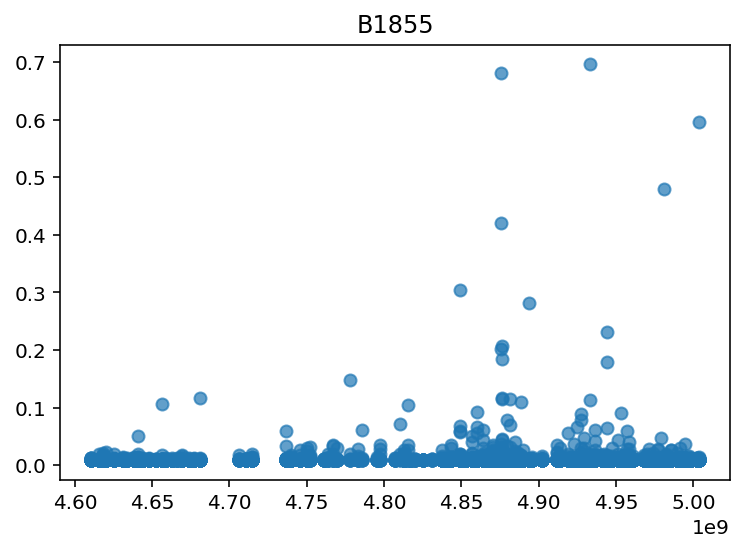

In [41]:
plt.scatter(psrb.toas, (np.mean(gibbsb.poutchain, axis = 0)),alpha = 0.7)
plt.title('B1855')

Residual Plot

Text(0, 0.5, 'microsecond')

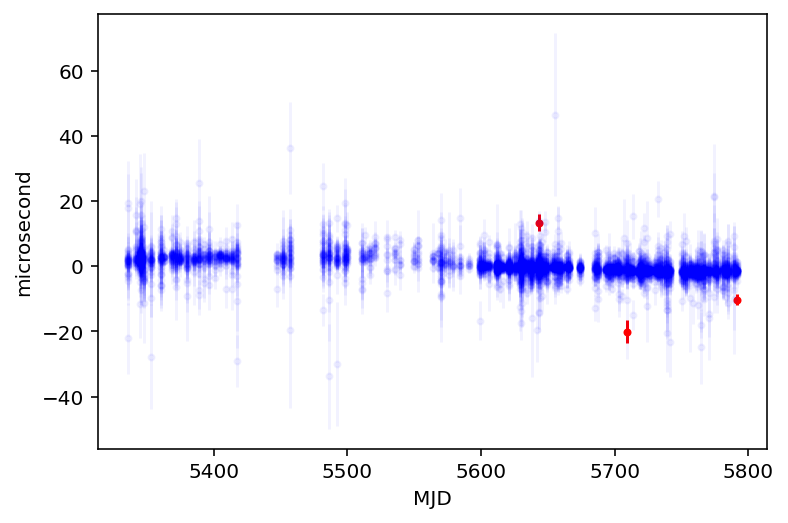

In [84]:
plt.errorbar(psrb.toas[mask1a]/864000,psrb.residuals[mask1a]/1e-6,yerr=psrb.toaerrs[mask1a]/1e-6,fmt='.',alpha=1.0,color='r')
plt.errorbar(psrb.toas[mask1b]/864000,psrb.residuals[mask1b]/1e-6,yerr=psrb.toaerrs[mask1b]/1e-6,fmt='.',alpha=0.05,color='b')
plt.xlabel('MJD')
plt.ylabel('microsecond')

In [42]:
ptaj = signal_base.PTA([s(psrj)])
gibbsj = Gibbs(ptaj, vary_df=True, theta_prior='beta', vary_alpha = True)

In [43]:
xs = np.array([p.sample() for p in gibbsj.params]).flatten()
gibbsj.sample(xs)

<ipython-input-23-829a14d1faba>:336: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.get_logpdf(x) for p, x in zip(self.params, xs))


Finished 99 percent in 5191.45 seconds.

Text(0.5, 1.0, 'J0023')

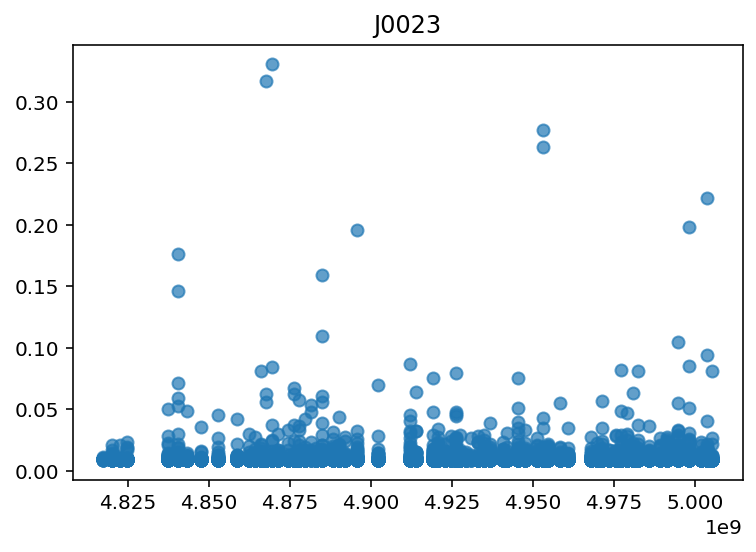

In [44]:
plt.scatter(psrj.toas, (np.mean(gibbsj.poutchain, axis = 0)),alpha = 0.7)
plt.title('J0023')

In [48]:
mask2a = tuple([np.mean(gibbsj.poutchain, axis = 0) >0.30])
mask2b = tuple([np.mean(gibbsj.poutchain, axis = 0) <= 0.30])

<ErrorbarContainer object of 3 artists>

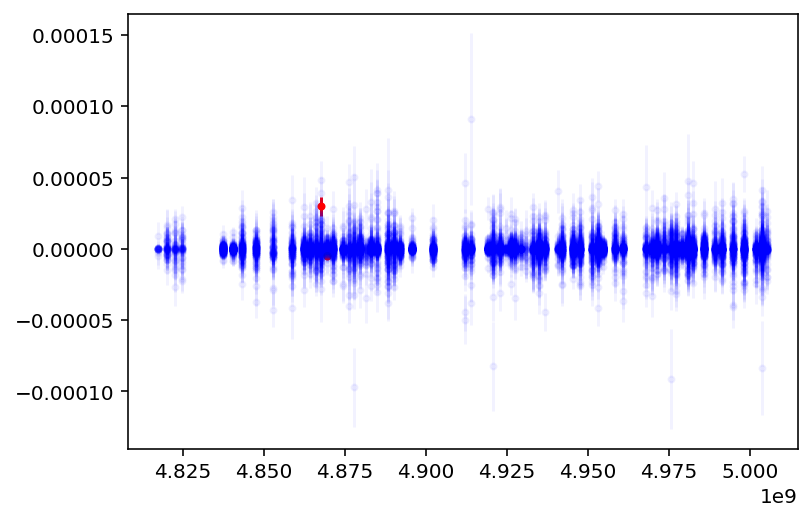

In [49]:
plt.errorbar(psrj.toas[mask2a],psrj.residuals[mask2a],yerr=psrj.toaerrs[mask2a],fmt='.',alpha=1.0,color='r')
plt.errorbar(psrj.toas[mask2b],psrj.residuals[mask2b],yerr=psrj.toaerrs[mask2b],fmt='.',alpha=0.05,color='b')